# **Final Project - Store Item Demand Forecasting**


*   Priyanka Dilip Shinde
*   Kunwar Rajesh Chopra

*   Sahil Sanjay Gadge.










---



## **Abstract**



> #### **The goal of this notebook is to develop and compare different approaches to time-series problems.** 





---



## **Data Visualization**

##### **Imports**

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [10]:
def load_data(datapath):
    data = pd.read_csv(datapath)
   # Dimensions
    print('Shape:', data.shape)
    # Set of features we have are: date, store, and item
    display(data.sample(10))
    return data
    
train_df = load_data('train 2.csv')

Shape: (913000, 4)


,date,store,item,sales
86734,2015-07-02,8,5,32
510077,2014-09-16,10,28,90
290288,2017-11-16,9,16,41
393219,2014-09-22,6,22,52
601094,2013-12-07,10,33,59
862231,2013-12-26,3,48,30
610009,2013-05-06,5,34,22
300611,2016-02-22,5,17,8
685610,2015-05-11,6,38,52
159365,2014-05-19,8,9,56


In [ ]:
def sales_dist(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    print()
    return sales_df

sales_df = sales_dist(train_df)

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

##### **Feature Engineering**

In [ ]:
def sales_data_understanding(data):    
    store_df = data.copy()
    #plt.figure(figsize=(20,10))
    sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
    #sales_pivoted_df.plot(kind="hist",figsize=(20,10))
    # Pivoted dataframe
    #display(sales_pivoted_df)
    return (store_df,sales_pivoted_df)

store_df,sales_pivoted_df = sales_data_understanding(train_df)

In [ ]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

##### **Visualization**



In [ ]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
fig.show(renderer="colab")
py.iplot(fig,filename='scatter_sales_store')

In [ ]:
def sales_insight(sales_pivoted_df):
    # Let us calculate the average sales of each of the item across all the stores
    sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
    sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
    # And finally, sort by avg sale
    avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
    # Display the top 10 rows
    display(avg_sales_per_item_across_stores_df.head())
    return (sales_across_item_df,avg_sales_per_item_across_stores_df)

sales_across_item_df,avg_sales_per_item_across_stores_df = sales_insight(sales_pivoted_df)


,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418


In [ ]:
avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
fig.show(renderer="colab")
py.iplot(fig,filename='scatter_sales_item')

# **Approach 1** - LightGBM

## LightGBM

LightGBM is a gradient boosting framework based on decision trees to increases the efficiency of the model and reduces memory usage. 

![](https://drive.google.com/uc?export=view&id=1951GYllF5HRoJL_8bFECTiPAuV1vVKW7)
![](https://drive.google.com/uc?export=view&id=15-5wmvnkntHFewrfg2m9TtspAhSRCoUW)

The main features of the LGBM model are as follows :

* Higher accuracy and a faster training speed

* Low memory utilization

* Comparatively better accuracy than other boosting algorithms and handles overfitting much better while working with smaller datasets

* Parallel Learning support

* Compatible with both small and large datasets

### **Imports**

In [1]:
#Loading libraries 
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import plotly.express as px

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [5]:
#importing data
data_train = pd.read_csv("train 2.csv", parse_dates=['date'])
data_test = pd.read_csv("test.csv", parse_dates=['date'])
data = pd.concat([data_train, data_test], sort=False)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958000 entries, 0 to 44999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    958000 non-null  datetime64[ns]
 1   store   958000 non-null  int64         
 2   item    958000 non-null  int64         
 3   sales   913000 non-null  float64       
 4   id      45000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.9 MB


### **Feature Engineering**

In [7]:
#to create new features with date column
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday 
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

data = create_date_features(data)

In [8]:
data.head(10)

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,1,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,2,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,3,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,4,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,5,0,0
5,2013-01-06,1,1,12.0,NaN,1,6,6,1,6,2013,6,0,0
6,2013-01-07,1,1,10.0,NaN,1,7,7,2,0,2013,0,0,0
7,2013-01-08,1,1,9.0,NaN,1,8,8,2,1,2013,1,0,0
8,2013-01-09,1,1,12.0,NaN,1,9,9,2,2,2013,2,0,0
9,2013-01-10,1,1,9.0,NaN,1,10,10,2,3,2013,3,0,0


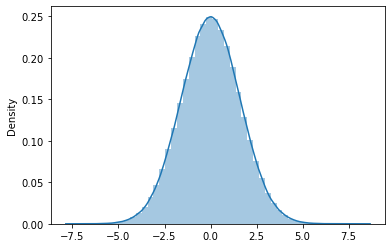

In [11]:
#Random noise
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

a = random_noise(data)

sns.distplot(a)
plt.show()

In [12]:
#Setting the feature order here, first we set it as store, item, date.
data.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [13]:
#Lag/Shifted Features
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


data = lag_features(data, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
data.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,1,0,0,42.545532,54.476238,65.569562,68.625186,68.005719,81.191046,74.215263,60.478122,98.164451,73.372246
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,2,0,0,60.507550,49.773226,65.422185,59.862942,76.145856,80.013759,81.001145,72.622480,79.246261,67.064657
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,3,0,0,56.266163,63.092856,70.797474,66.191557,70.611687,86.912402,81.890753,65.733006,97.366170,75.029557
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,4,0,0,75.535463,76.410376,73.553421,66.107551,65.836142,82.675842,91.711548,70.701556,80.493490,81.270813
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,5,0,1,60.298018,68.464840,55.077816,70.105741,48.168607,76.886904,100.439315,100.078582,96.852891,80.240900


In [14]:
#Rolling Mean Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


data = roll_mean_features(data, [365, 546])
data.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,1,0,0,42.545532,54.476238,65.569562,68.625186,68.005719,81.191046,74.215263,60.478122,98.164451,73.372246,90.032099,84.828756
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,2,0,0,60.507550,49.773226,65.422185,59.862942,76.145856,80.013759,81.001145,72.622480,79.246261,67.064657,87.995653,85.772034
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,3,0,0,56.266163,63.092856,70.797474,66.191557,70.611687,86.912402,81.890753,65.733006,97.366170,75.029557,87.805349,87.719737
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,4,0,0,75.535463,76.410376,73.553421,66.107551,65.836142,82.675842,91.711548,70.701556,80.493490,81.270813,88.412401,86.283928
44999,2018-03-31,10,50,NaN,44999.0,3,31,90,13,5,2018,5,0,1,60.298018,68.464840,55.077816,70.105741,48.168607,76.886904,100.439315,100.078582,96.852891,80.240900,88.050014,84.839468


In [15]:
#Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

data = ewm_features(data, alphas, lags)

data.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,1,0,0,42.545532,54.476238,65.569562,68.625186,68.005719,81.191046,74.215263,60.478122,98.164451,73.372246,90.032099,84.828756,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,2,0,0,60.507550,49.773226,65.422185,59.862942,76.145856,80.013759,81.001145,72.622480,79.246261,67.064657,87.995653,85.772034,61.928089,51.151419,66.969374,60.367468,89.594786,118.671075,60.337210,80.730889,68.198973,60.924437,51.319799,66.884978,60.678577,89.177758,118.368217,60.747330,81.256156,68.311547,59.191088,51.775931,66.599234,61.172313,88.297764,117.740676,61.771911,81.872309,68.367714,57.927500,52.472938,66.228436,61.543247,87.348615,116.916565,63.027108,82.174524,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,3,0,0,56.266163,63.092856,70.797474,66.191557,70.611687,86.912402,81.890753,65.733006,97.366170,75.029557,87.805349,87.719737,59.146404,62.407571,71.748469,65.718373,102.329739,119.933554,72.366861,98.086544,74.659949,59.192444,61.831980,71.488498,65.467858,101.617776,119.836822,71.774733,97.225616,74.331155,59.038218,60.755186,70.919847,65.034463,100.059553,119.548135,70.754382,95.574462,73.673543,58.678250,59.841881,70.268531,64.662974,98.304585,119.074969,70.008132,93.952357,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,4,0,0,75.535463,76.410376,73.553421,66.107551,65.836142,82.675842,91.711548,70.701556,80.493490,81.270813,88.412401,86.283928,73.257320,74.370379,71.987423,66.935919,99.166487,100.046678,68.218343,79.954327,82.582997,72.519244,73.683198,71.948850,66.846786,99.261778,101.083682,68.377473,80.822562,82.133115,71.007644,72.151037,71.783969,66.606893,99.211911,103.109627,68.550876,82.314892,81.134709,69.403475,70.452564,71.480559,66.298892,98.791375,105.022491,68.602440,83.485707,80.000156,66.038719,66.956088,70.379233,65.5418

In [16]:
#One-Hot Encoding
data = pd.get_dummies(data, columns=['day_of_week', 'month'])
data.head()

,date,store,item,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,1,1,13.0,NaN,1,1,1,2013,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,1,1,11.0,NaN,2,2,1,2013,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,1,1,14.0,NaN,3,3,1,2013,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,1,1,13.0,NaN,4,4,1,2013,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,1,1,10.0,NaN,5,5,1,2013,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [17]:
#Converting sales to log(1+sales)
data['sales'] = np.log1p(data["sales"].values)
data.head()

,date,store,item,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,1,1,2.639057,NaN,1,1,1,2013,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,1,1,2.484907,NaN,2,2,1,2013,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,1,1,2.708050,NaN,3,3,1,2013,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,1,1,2.639057,NaN,4,4,1,2013,4,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,1,1,2.397895,NaN,5,5,1,2013,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


### **Train-Validation Split**

In [18]:
# Train set until the beginning of 2017 (until the end of 2016).
train = data.loc[(data["date"] < "2017-01-01"), :]

In [19]:
# First three months of 2017 validation set.
val = data.loc[(data["date"] >= "2017-01-01") & (data["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [20]:
# Selecting the dependent and independent variable for the train set
Y_train = train['sales']
X_train = train[cols]

In [21]:
# Choosing the dependent and independent variable for the validation set
Y_val = val['sales']
X_val = val[cols]

In [22]:
Y_train.shape, Y_train.shape, Y_val.shape, X_val.shape

((730500,), (730500,), (45000,), (45000, 84))

### **Base Model**

In [24]:
model1 = lgb.LGBMRegressor(learning_rate=0.02,max_depth=5,random_state=42, num_leaves=10, metric='mae',n_estimators=1000,
              early_stopping_rounds=200)
model1.fit(X_train,Y_train,eval_set=[(X_val,Y_val),(X_train,Y_train)],
          verbose=20,eval_metric='logloss')

Training until validation scores don't improve for 200 rounds
[20]	training's l1: 0.34504	valid_0's l1: 0.333433
[40]	training's l1: 0.266516	valid_0's l1: 0.260272
[60]	training's l1: 0.219417	valid_0's l1: 0.215703
[80]	training's l1: 0.190268	valid_0's l1: 0.187833
[100]	training's l1: 0.172283	valid_0's l1: 0.171091
[120]	training's l1: 0.160984	valid_0's l1: 0.161602
[140]	training's l1: 0.153559	valid_0's l1: 0.155277
[160]	training's l1: 0.148264	valid_0's l1: 0.150689
[180]	training's l1: 0.144574	valid_0's l1: 0.147206
[200]	training's l1: 0.141877	valid_0's l1: 0.144839
[220]	training's l1: 0.140061	valid_0's l1: 0.143211
[240]	training's l1: 0.138734	valid_0's l1: 0.142121
[260]	training's l1: 0.137778	valid_0's l1: 0.141347
[280]	training's l1: 0.137059	valid_0's l1: 0.140755
[300]	training's l1: 0.136461	valid_0's l1: 0.140269
[320]	training's l1: 0.135949	valid_0's l1: 0.139859
[340]	training's l1: 0.135493	valid_0's l1: 0.139512
[360]	training's l1: 0.135099	valid_0's l1

LGBMRegressor(early_stopping_rounds=200, learning_rate=0.02, max_depth=5,
              metric='mae', n_estimators=1000, num_leaves=10, random_state=42)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l1'>

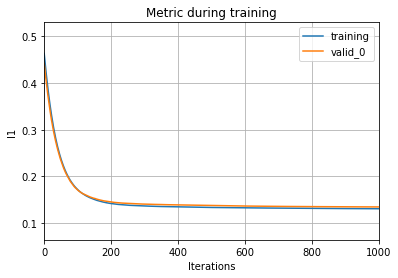

In [ ]:
#plotting the metric evaluation 
lgb.plot_metric(model1)

In [ ]:
#function for plotting the feature importance graph
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

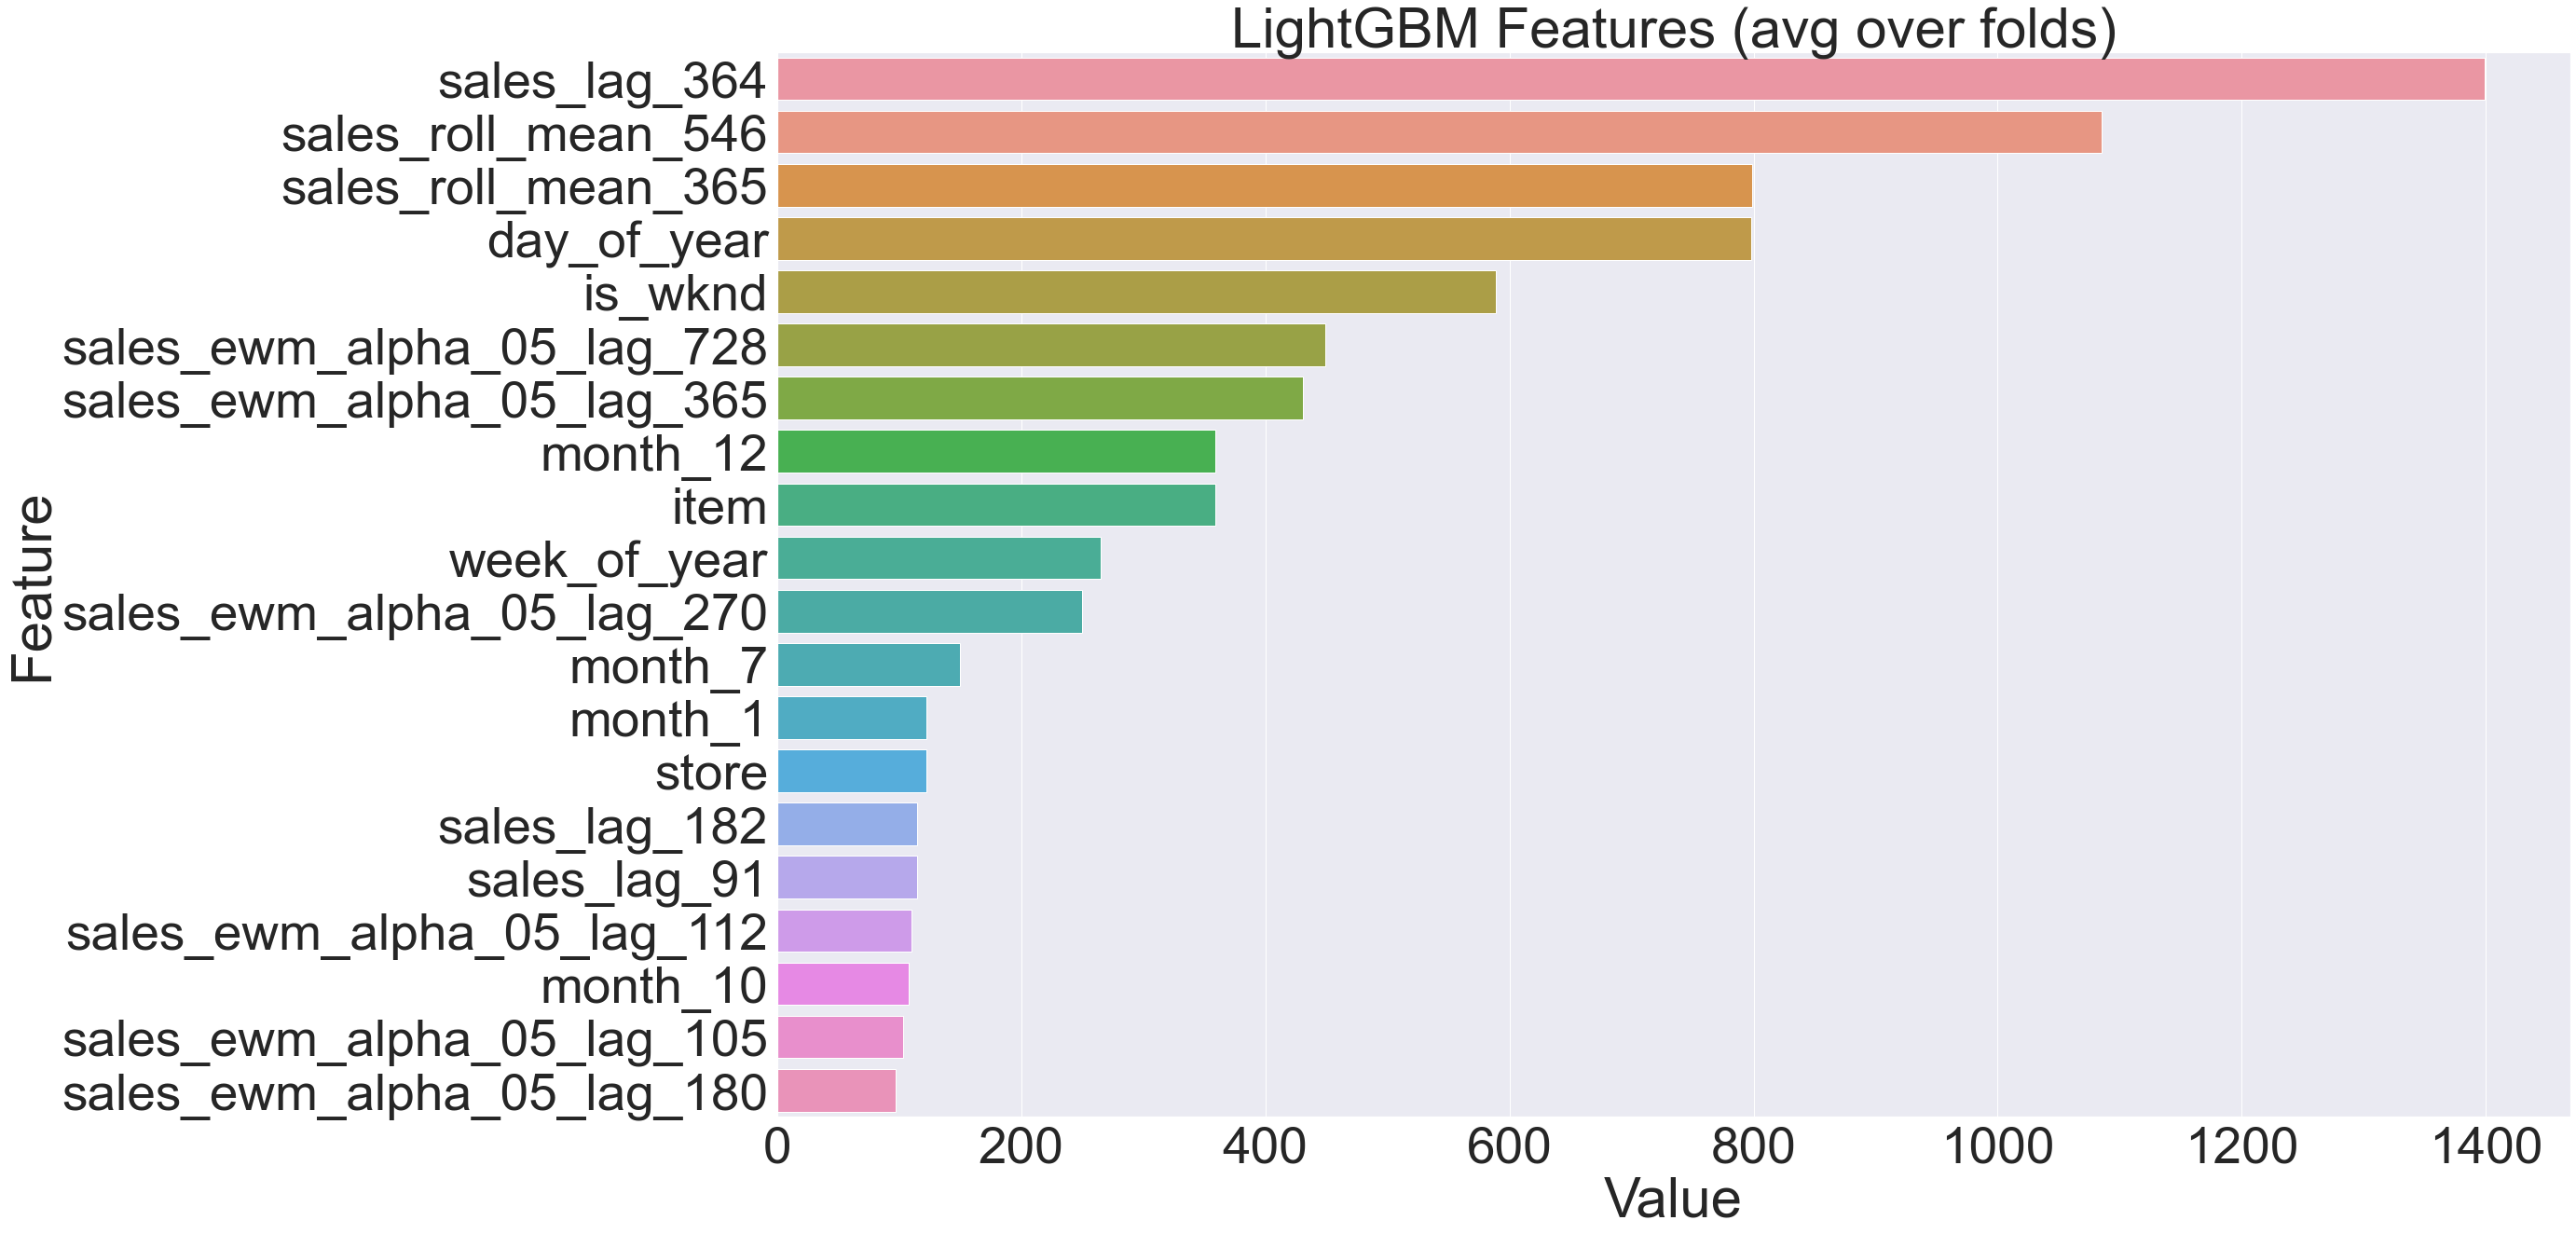

In [ ]:
#plotting the feature importance graph
plotImp(model1, X_train)

#### **Visualization of store 1 item 1 forecast**

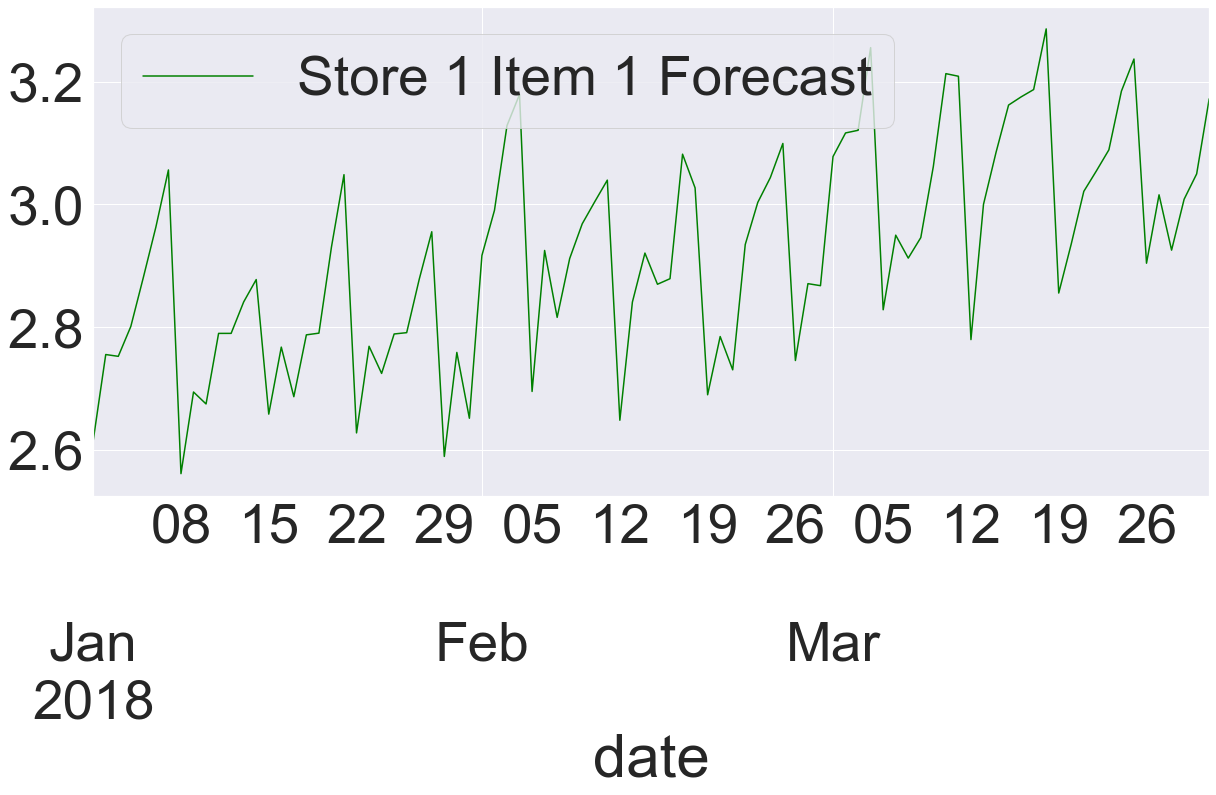

In [ ]:
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

In [ ]:
train = data.loc[~data.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = data.loc[data.sales.isna()]
X_test = test[cols]

In [ ]:
test_preds = model1.predict(X_test)

#### **Visualization of store 1 item 17 actual and forecasted sales**

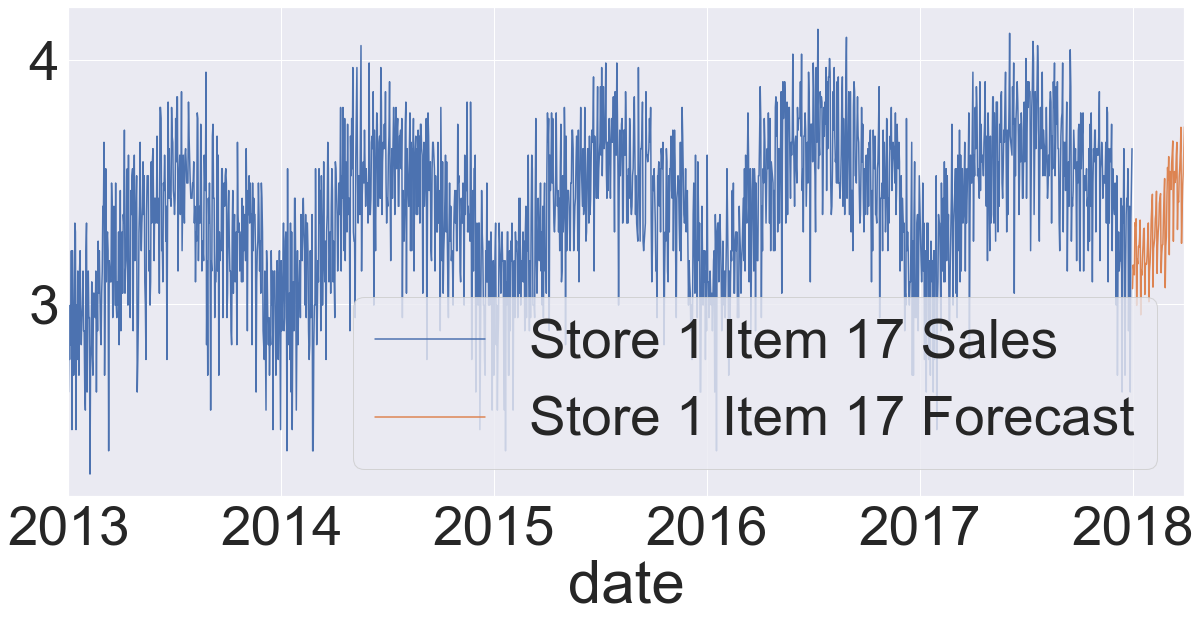

In [ ]:
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");


### **Hyperparameter Tuning**

Setting num_leaves = 31 and max_depth = 20

In [ ]:
model2 = lgb.LGBMRegressor(learning_rate=0.02,max_depth=20,random_state=42, num_leaves=31, metric='mae',n_estimators=1000,
              early_stopping_rounds=200)
model2.fit(X_train,Y_train,eval_set=[(X_val,Y_val),(X_train,Y_train)],
          verbose=20,eval_metric='logloss')

Training until validation scores don't improve for 200 rounds
[20]	training's l1: 0.336938	valid_0's l1: 0.326972
[40]	training's l1: 0.251245	valid_0's l1: 0.24612
[60]	training's l1: 0.199679	valid_0's l1: 0.197334
[80]	training's l1: 0.169827	valid_0's l1: 0.169839
[100]	training's l1: 0.152859	valid_0's l1: 0.154789
[120]	training's l1: 0.143501	valid_0's l1: 0.146725
[140]	training's l1: 0.138179	valid_0's l1: 0.142231
[160]	training's l1: 0.135214	valid_0's l1: 0.139815
[180]	training's l1: 0.133491	valid_0's l1: 0.138475
[200]	training's l1: 0.132379	valid_0's l1: 0.137601
[220]	training's l1: 0.131607	valid_0's l1: 0.136986
[240]	training's l1: 0.131023	valid_0's l1: 0.136495
[260]	training's l1: 0.130572	valid_0's l1: 0.136087
[280]	training's l1: 0.130202	valid_0's l1: 0.1357
[300]	training's l1: 0.129872	valid_0's l1: 0.135412
[320]	training's l1: 0.129582	valid_0's l1: 0.135119
[340]	training's l1: 0.129333	valid_0's l1: 0.134872
[360]	training's l1: 0.129103	valid_0's l1: 

LGBMRegressor(early_stopping_rounds=200, learning_rate=0.02, max_depth=20,
              metric='mae', num_boost_round=1000, random_state=42)

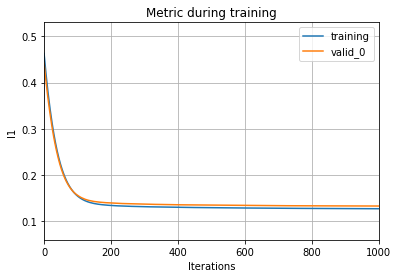

In [ ]:
#plotting the metric evaluation 
lgb.plot_metric(model2)

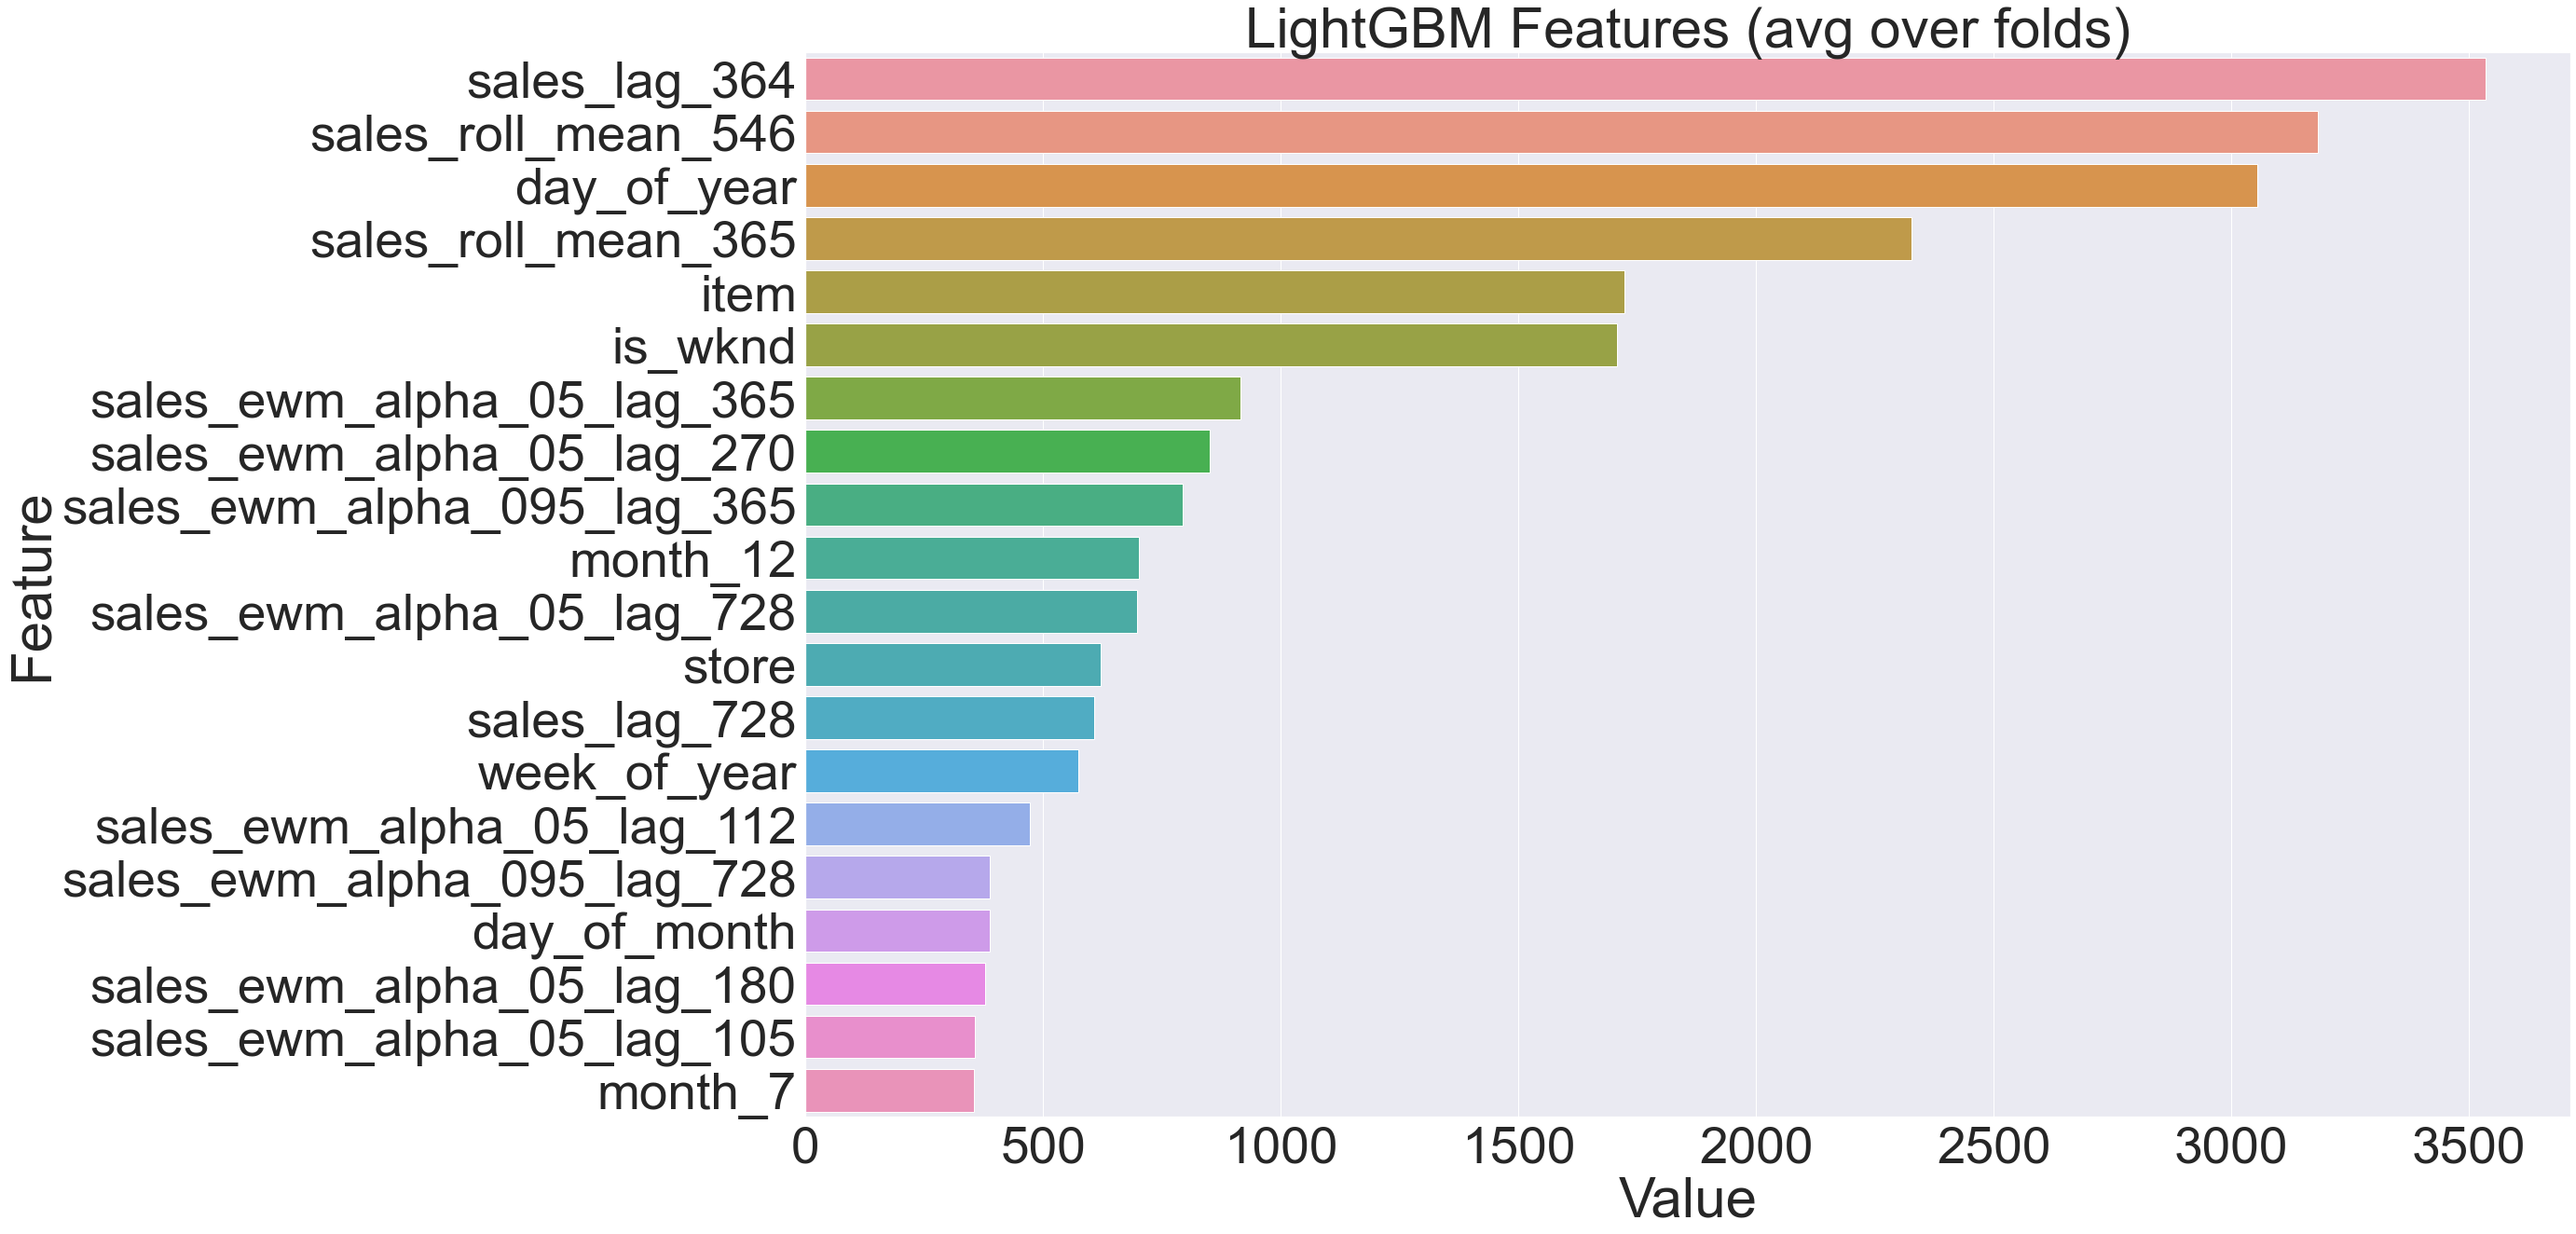

In [ ]:
#plotting the feature importance graph
plotImp(model2, X_train)

In [ ]:
test_preds2 = model2.predict(X_test)

#### **Visualization of store 1 item 1 forecast**

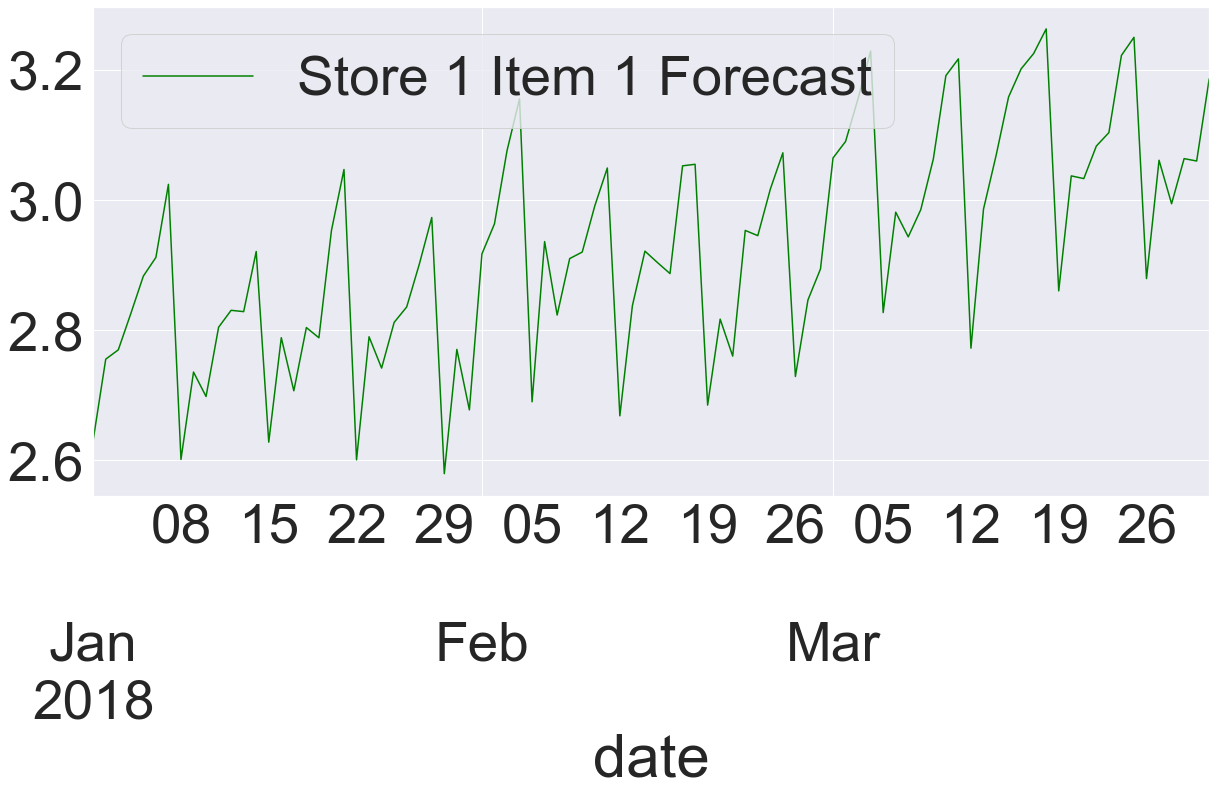

In [ ]:
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds2
                        })

forecast[(forecast.store == 1) & (forecast.item == 1)].set_index("date").sales.plot(color = "green",
                                                                                    figsize = (20,9),
                                                                                    legend=True, label = "Store 1 Item 1 Forecast");

#### **Visualization of store 1 item 17 actual and forecasted sales** 

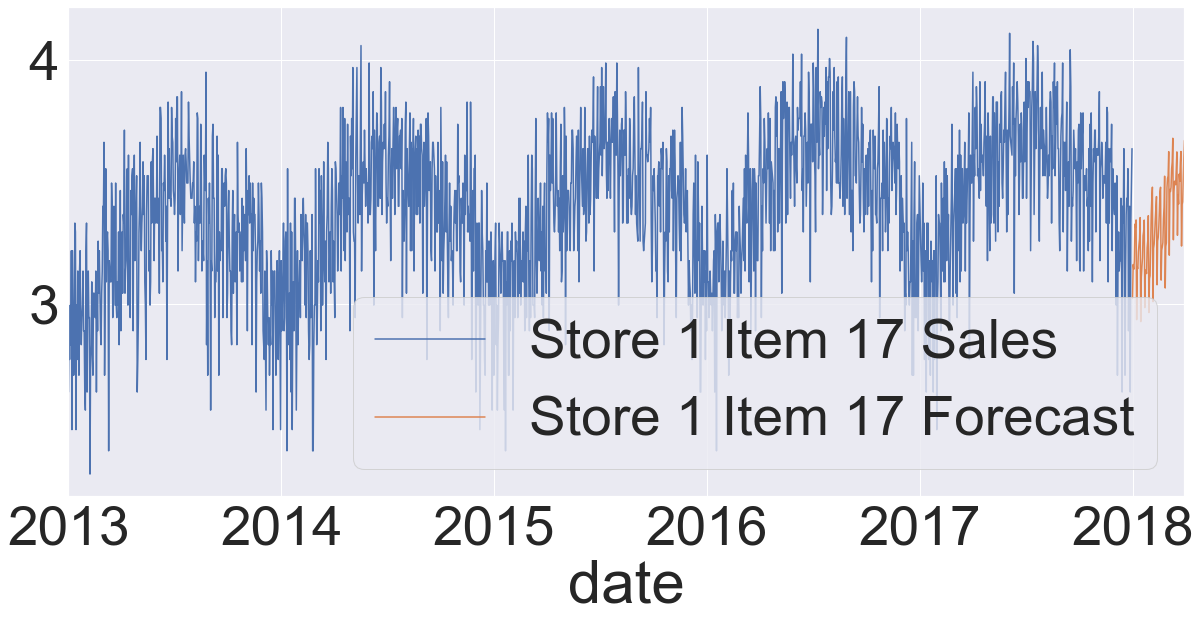

In [ ]:
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");


#### Visualization of store 1 item 17 actual and forecasted sales 

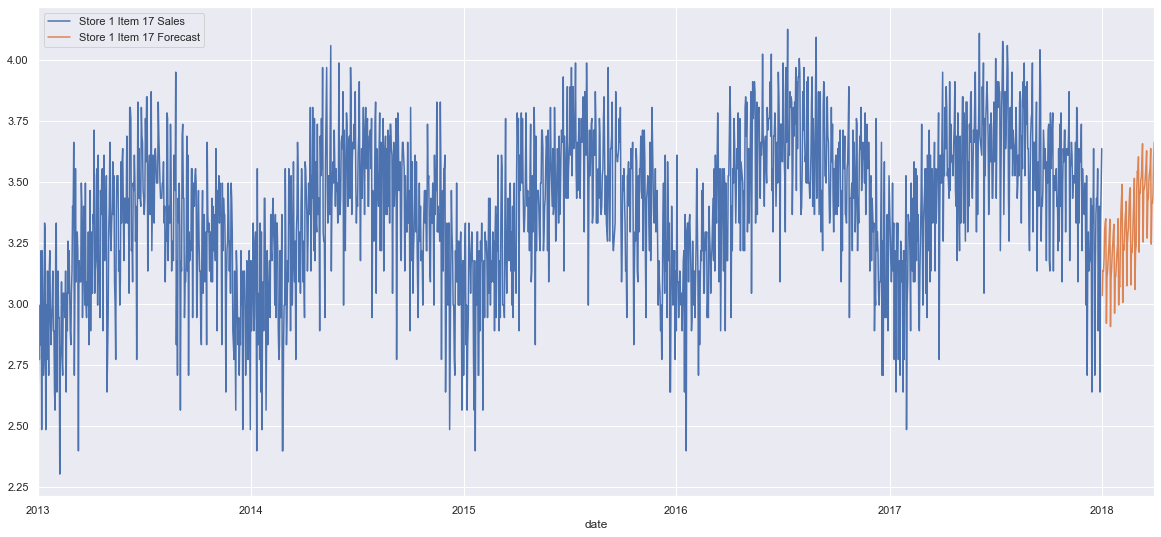

In [ ]:
train[(train.store == 1) & (train.item == 17)].set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Store 1 Item 17 Sales")
forecast[(forecast.store == 1) & (forecast.item == 17)].set_index("date").sales.plot(legend=True, label = "Store 1 Item 17 Forecast");


### **Conclusion** 

Model after hyperparameter tuning gives better result than first model.

# **Approach 2** - Deep Learning

## **Import**

In [ ]:

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")
# Set seeds to make the experiment more reproducible.
import tensorflow
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

In [ ]:
train = pd.read_csv('train.csv', parse_dates=['date'])

In [ ]:
# collect values of each (item, store, date) by groupby(). sort the data by 'date'.
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
# get the mean 'sales' of each (item, store, date).
train_gp = train_gp.agg({'sales':['mean']})
#set the layout of dataframe (4 columns, [item, store, date, sales])
train_gp.columns = ['item', 'store', 'date', 'sales']
#print
train_gp.head()

,item,store,date,sales
0,1,1,2013-01-01,13.0
1,1,1,2013-01-02,11.0
2,1,1,2013-01-03,14.0
3,1,1,2013-01-04,13.0
4,1,1,2013-01-05,10.0


In [ ]:
train_gp.nunique()

item       37
store      10
date     1826
sales     213
dtype: int64

### **Transform the data**



> Lag Features


Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The simplest approach is to predict the value at the next time (t+1) given the value at the previous time (t-1).



> Window

The addition of lag features is called the sliding window method, in this case with a window width of 29. It is as though we are sliding our focus along the time series for each observation with an interest in only what is within the window width.

We can expand the window width and include more lagged features.

https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/





*   shift(i) shifts the row of data with i steps. Fill NaN value for empty slots.
*   By shifting and concatenating the columns, we can use single row as training data sample. It contains the data from t-n to t, and target value t+lag.

*   Drop rows with NaN values which was created by shift() function.
*   After droping rows, the data starts with index == window.





In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    '''
    The Pandas library provides the shift() function 
    to help create these shifted or lag features from a time series dataset. 
    Shifting the dataset by 1 creates the t-1 column, 
    adding a NaN (unknown) value for the first row. 
    The time series dataset without a shift represents the t+1.
    '''
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    '''
    We can concatenate the shifted columns together into a new DataFrame 
    using the concat() function along the column axis (axis=1).'''
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
window = 29
lag = 90
#Create a dataset to predict the value of t+lag using t-window ~ t data.
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,13.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,11.0,1.0,1.0,6.0,1,1,9.0,1.0,1.0,15.0
30,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,...,6.0,1.0,1.0,9.0,1,1,13.0,1.0,1.0,16.0
31,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,...,9.0,1.0,1.0,13.0,1,1,11.0,1.0,1.0,23.0
32,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,...,13.0,1.0,1.0,11.0,1,1,21.0,1.0,1.0,22.0
33,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,...,11.0,1.0,1.0,21.0,1,1,15.0,1.0,1.0,20.0


In [ ]:
#filter the data to have same item-id, store-id over a column.
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [ ]:
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,13.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,...,11.0,1.0,1.0,6.0,1,1,9.0,1.0,1.0,15.0
30,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,...,6.0,1.0,1.0,9.0,1,1,13.0,1.0,1.0,16.0
31,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,...,9.0,1.0,1.0,13.0,1,1,11.0,1.0,1.0,23.0
32,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,12.0,1.0,...,13.0,1.0,1.0,11.0,1,1,21.0,1.0,1.0,22.0
33,1.0,1.0,10.0,1.0,1.0,12.0,1.0,1.0,10.0,1.0,...,11.0,1.0,1.0,21.0,1,1,15.0,1.0,1.0,20.0


In [ ]:
#drop the information about item and store.
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
#We only want to model the sales value.
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

### **Train/validation split**

In [ ]:
labels_col = 'sales(t+%d)' % 90
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (392466, 30)
Validation set shape (261644, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
557107,44.0,36.0,45.0,53.0,56.0,37.0,40.0,26.0,49.0,37.0,...,40.0,52.0,55.0,41.0,56.0,56.0,37.0,41.0,33.0,41.0
651730,60.0,76.0,73.0,73.0,89.0,100.0,59.0,72.0,84.0,70.0,...,65.0,68.0,83.0,74.0,69.0,78.0,90.0,68.0,56.0,63.0
379504,42.0,49.0,44.0,55.0,29.0,37.0,42.0,39.0,54.0,45.0,...,37.0,47.0,64.0,45.0,51.0,24.0,44.0,55.0,54.0,50.0
430732,75.0,82.0,49.0,55.0,52.0,58.0,64.0,80.0,59.0,47.0,...,84.0,67.0,64.0,60.0,51.0,65.0,60.0,66.0,86.0,88.0
84953,21.0,14.0,13.0,9.0,8.0,13.0,13.0,25.0,21.0,11.0,...,12.0,16.0,9.0,16.0,16.0,16.0,14.0,21.0,14.0,14.0


## **MLP**

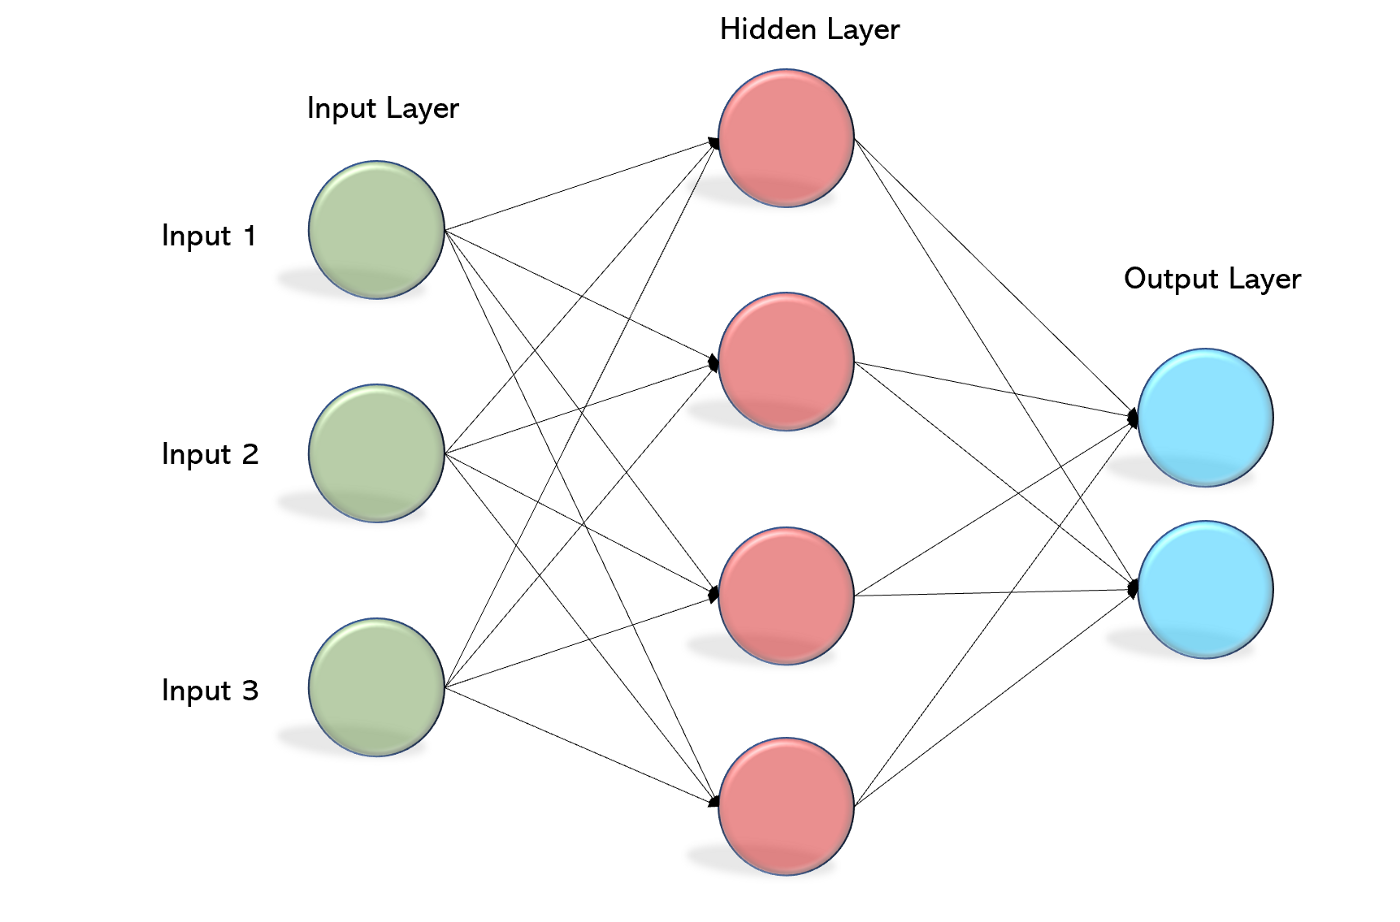



> A multilayer perceptron (MLP) is a feedforward artificial neural network that generates a set of outputs from a set of inputs. An MLP is characterized by several layers of input nodes connected as a directed graph between the input and output layers. MLP uses backpropogation for training the network. MLP is a deep learning method.






*   First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
*   The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.





In [ ]:
#Set Training Configuration
#40 epochs with minibatch_size=256, learning_rate = 0.0003 training with Adam optimizer.
epochs = 40
batch = 256
lr = 0.0003
import tensorflow as tf

adam = tf.optimizers.Adam(lr)

In [ ]:
#2 layer MLP with ReLU activation, trained with mse loss.
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3100      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit the mlp model on trainset. test the performance with validation_data.
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 7s - loss: 396.4911 - val_loss: 371.0771 - 7s/epoch - 2ms/step
Epoch 2/40
3149/3149 - 7s - loss: 363.6005 - val_loss: 362.2590 - 7s/epoch - 2ms/step
Epoch 3/40
3149/3149 - 7s - loss: 357.9643 - val_loss: 373.4828 - 7s/epoch - 2ms/step
Epoch 4/40
3149/3149 - 6s - loss: 356.4803 - val_loss: 383.9130 - 6s/epoch - 2ms/step
Epoch 5/40
3149/3149 - 7s - loss: 355.3464 - val_loss: 356.3162 - 7s/epoch - 2ms/step
Epoch 6/40
3149/3149 - 7s - loss: 353.8388 - val_loss: 352.7443 - 7s/epoch - 2ms/step
Epoch 7/40
3149/3149 - 7s - loss: 352.6495 - val_loss: 356.8575 - 7s/epoch - 2ms/step
Epoch 8/40
3149/3149 - 7s - loss: 351.5346 - val_loss: 349.5616 - 7s/epoch - 2ms/step
Epoch 9/40
3149/3149 - 7s - loss: 351.0129 - val_loss: 354.8997 - 7s/epoch - 2ms/step
Epoch 10/40
3149/3149 - 7s - loss: 349.6908 - val_loss: 350.1218 - 7s/epoch - 2ms/step
Epoch 11/40
3149/3149 - 7s - loss: 348.9591 - val_loss: 347.6833 - 7s/epoch - 2ms/step
Epoch 12/40
3149/3149 - 7s - loss: 347.3473 - val_lo

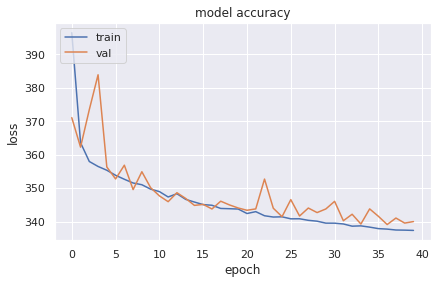

In [ ]:
#plot train loss and validation loss

from matplotlib import pyplot as plt
history = mlp_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **Hyperparameter Tuning**

##### **MLP (Adadelta, Epoch - 50, lr = 0.001)**

In [ ]:
#Set Training Configuration
#40 epochs with minibatch_size=256, learning_rate = 0.0003 training with Adam optimizer.
epochs = 50
batch = 256
lr = 0.001
import tensorflow as tf

adadelta = tf.optimizers.Adadelta(
    learning_rate=lr,
    name='Adadelta',
)

In [ ]:
#2 layer MLP with ReLU activation, trained with mse loss.
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adadelta)
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit the mlp model on trainset. test the performance with validation_data.
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/50
12265/12265 - 23s - loss: 2718.3884 - val_loss: 436.0073 - 23s/epoch - 2ms/step
Epoch 2/50
12265/12265 - 23s - loss: 426.0775 - val_loss: 413.9760 - 23s/epoch - 2ms/step
Epoch 3/50
12265/12265 - 21s - loss: 408.2120 - val_loss: 399.7197 - 21s/epoch - 2ms/step
Epoch 4/50
12265/12265 - 23s - loss: 396.9195 - val_loss: 390.2477 - 23s/epoch - 2ms/step
Epoch 5/50
12265/12265 - 20s - loss: 388.2996 - val_loss: 382.4626 - 20s/epoch - 2ms/step
Epoch 6/50
12265/12265 - 20s - loss: 381.3374 - val_loss: 376.4171 - 20s/epoch - 2ms/step
Epoch 7/50
12265/12265 - 23s - loss: 376.1674 - val_loss: 371.9050 - 23s/epoch - 2ms/step
Epoch 8/50
12265/12265 - 20s - loss: 372.1451 - val_loss: 368.1924 - 20s/epoch - 2ms/step
Epoch 9/50
12265/12265 - 20s - loss: 368.6767 - val_loss: 365.1250 - 20s/epoch - 2ms/step
Epoch 10/50
12265/12265 - 24s - loss: 365.6740 - val_loss: 362.2830 - 24s/epoch - 2ms/step
Epoch 11/50
12265/12265 - 36s - loss: 363.0513 - val_loss: 359.7740 - 36s/epoch - 3ms/step
Epoch 1

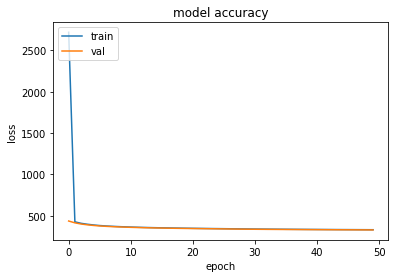

In [ ]:
#plot train loss and validation loss

from matplotlib import pyplot as plt
history = mlp_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#MLP
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 18.311103459496913
Validation rmse: 18.438917373766753


In [ ]:
#MLP
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 18.183612457770394
Validation rmse: 18.12297325749641


##### **MLP (Adagrad, Epoch - 30, lr = 0.01)**

In [ ]:
#Set Training Configuration
#40 epochs with minibatch_size=256, learning_rate = 0.0003 training with Adam optimizer.
epochs = 30
batch = 256
lr = 0.01
import tensorflow as tf

adadelta = tf.optimizers.Adagrad(
    learning_rate=lr,
    name='Adadelta',
)

In [ ]:
#2 layer MLP with ReLU activation, trained with mse loss.
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adadelta)
model_mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               3100      
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#fit the mlp model on trainset. test the performance with validation_data.
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/30
12265/12265 - 23s - loss: 330.6958 - val_loss: 310.0738 - 23s/epoch - 2ms/step
Epoch 2/30
12265/12265 - 21s - loss: 310.7051 - val_loss: 305.6405 - 21s/epoch - 2ms/step
Epoch 3/30
12265/12265 - 23s - loss: 307.1033 - val_loss: 303.3708 - 23s/epoch - 2ms/step
Epoch 4/30
12265/12265 - 24s - loss: 305.5596 - val_loss: 304.8075 - 24s/epoch - 2ms/step
Epoch 5/30
12265/12265 - 23s - loss: 304.4645 - val_loss: 302.1145 - 23s/epoch - 2ms/step
Epoch 6/30
12265/12265 - 23s - loss: 303.6948 - val_loss: 300.8892 - 23s/epoch - 2ms/step
Epoch 7/30
12265/12265 - 23s - loss: 303.1159 - val_loss: 300.5635 - 23s/epoch - 2ms/step
Epoch 8/30
12265/12265 - 21s - loss: 302.5952 - val_loss: 299.8964 - 21s/epoch - 2ms/step
Epoch 9/30
12265/12265 - 21s - loss: 302.1723 - val_loss: 299.4900 - 21s/epoch - 2ms/step
Epoch 10/30
12265/12265 - 21s - loss: 301.7357 - val_loss: 299.1908 - 21s/epoch - 2ms/step
Epoch 11/30
12265/12265 - 24s - loss: 301.3846 - val_loss: 299.2678 - 24s/epoch - 2ms/step
Epoch 12

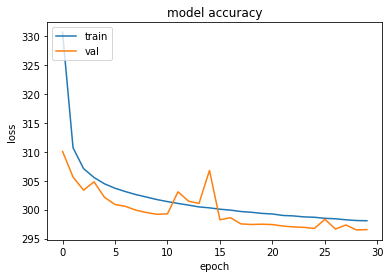

In [ ]:
#plot train loss and validation loss

from matplotlib import pyplot as plt
history = mlp_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#MLP
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 17.252252724403974
Validation rmse: 17.22032092983257


## **CNN**

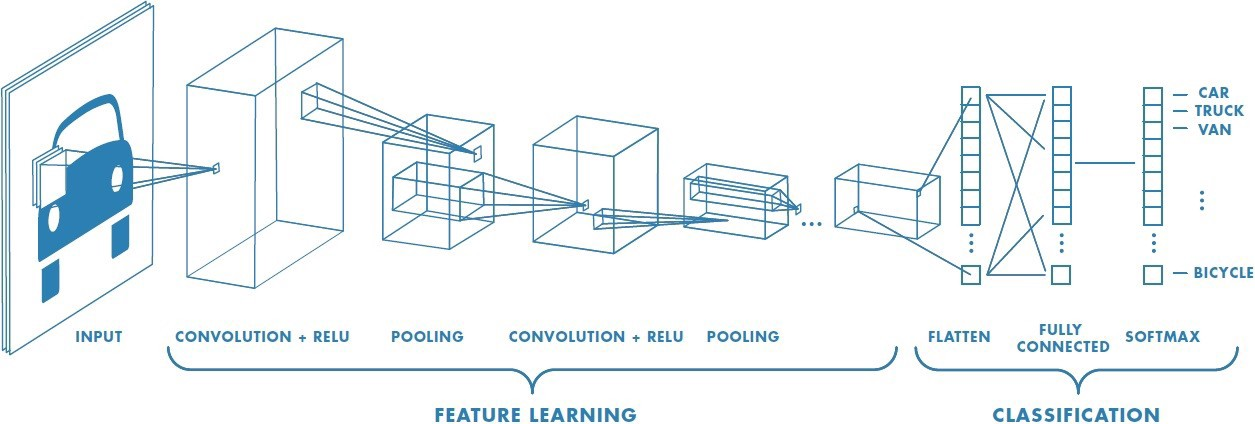

In deep learning, a convolutional neural network (CNN, or ConvNet) is a class of artificial neural networks, most commonly applied to analyze visual imagery. They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on the shared-weight architecture of the convolution kernels or filters that slide along input features and provide translation equivariant responses known as feature maps.



*   Use Conv1D and Maxpool to get a feature of given sequential data. Process this hidden feature with 2 Layer MLP. Predict the value of t+lag, and training the model with mse loss.




In [ ]:
#reshape the data as sequential data with scalar feature.
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [ ]:
#Use Conv1D and Maxpool to get a feature of given sequential data. 
#Process this hidden feature with 2 Layer MLP. Predict the value of t+lag, and training the model with mse loss.
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                44850     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
__________________________________________________

In [ ]:
#train
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 13s - loss: 415.6956 - val_loss: 387.3594 - 13s/epoch - 4ms/step
Epoch 2/40
3149/3149 - 12s - loss: 384.3950 - val_loss: 380.7798 - 12s/epoch - 4ms/step
Epoch 3/40
3149/3149 - 14s - loss: 373.0980 - val_loss: 374.4720 - 14s/epoch - 4ms/step
Epoch 4/40
3149/3149 - 18s - loss: 368.4092 - val_loss: 381.3375 - 18s/epoch - 6ms/step
Epoch 5/40
3149/3149 - 10s - loss: 366.6580 - val_loss: 366.5718 - 10s/epoch - 3ms/step
Epoch 6/40
3149/3149 - 13s - loss: 364.7402 - val_loss: 361.7381 - 13s/epoch - 4ms/step
Epoch 7/40
3149/3149 - 14s - loss: 363.2614 - val_loss: 367.0972 - 14s/epoch - 4ms/step
Epoch 8/40
3149/3149 - 10s - loss: 362.1298 - val_loss: 358.5634 - 10s/epoch - 3ms/step
Epoch 9/40
3149/3149 - 11s - loss: 361.5669 - val_loss: 365.8694 - 11s/epoch - 3ms/step
Epoch 10/40
3149/3149 - 10s - loss: 359.9788 - val_loss: 355.8369 - 10s/epoch - 3ms/step
Epoch 11/40
3149/3149 - 10s - loss: 357.8437 - val_loss: 353.4835 - 10s/epoch - 3ms/step
Epoch 12/40
3149/3149 - 13s - 

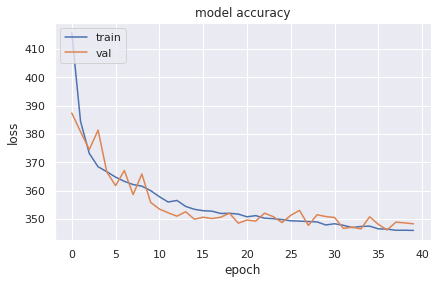

In [ ]:
#plot the loss
from matplotlib import pyplot as plt
history = cnn_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **Hyperparameter Tuning**

##### **CNN (Adadelta, Epoch - 50, lr = 0.01)**

In [ ]:
#reshape the data as sequential data with scalar feature.
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (392466, 30, 1)
Validation set shape (261644, 30, 1)


In [ ]:
#Set Training Configuration
#40 epochs with minibatch_size=256, learning_rate = 0.0003 training with Adam optimizer.
epochs = 50
batch = 256
lr = 0.01
import tensorflow as tf

adadelta = tf.optimizers.Adadelta(
    learning_rate=lr,
    name='Adadelta',
)

In [ ]:
#Use Conv1D and Maxpool to get a feature of given sequential data. 
#Process this hidden feature with 2 Layer MLP. Predict the value of t+lag, and training the model with mse loss.
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adadelta)
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 896)               0         
                                                                 
 dense_10 (Dense)            (None, 50)                44850     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
__________________________________________________

In [ ]:
#fit the mlp model on trainset. test the performance with validation_data.
cnn_history = model_cnn.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/50
12265/12265 - 92s - loss: 374.3534 - val_loss: 341.6629 - 92s/epoch - 7ms/step
Epoch 2/50
12265/12265 - 51s - loss: 340.3723 - val_loss: 334.1752 - 51s/epoch - 4ms/step
Epoch 3/50
12265/12265 - 63s - loss: 335.4331 - val_loss: 330.6070 - 63s/epoch - 5ms/step
Epoch 4/50
12265/12265 - 62s - loss: 332.5705 - val_loss: 328.3503 - 62s/epoch - 5ms/step
Epoch 5/50
12265/12265 - 63s - loss: 330.1650 - val_loss: 326.4425 - 63s/epoch - 5ms/step
Epoch 6/50
12265/12265 - 54s - loss: 328.0664 - val_loss: 324.0554 - 54s/epoch - 4ms/step
Epoch 7/50
12265/12265 - 63s - loss: 326.0740 - val_loss: 322.1009 - 63s/epoch - 5ms/step
Epoch 8/50
12265/12265 - 53s - loss: 324.1267 - val_loss: 320.2290 - 53s/epoch - 4ms/step
Epoch 9/50
12265/12265 - 53s - loss: 322.1492 - val_loss: 318.1901 - 53s/epoch - 4ms/step
Epoch 10/50
12265/12265 - 62s - loss: 320.0576 - val_loss: 316.2508 - 62s/epoch - 5ms/step
Epoch 11/50
12265/12265 - 40s - loss: 317.9556 - val_loss: 314.2133 - 40s/epoch - 3ms/step
Epoch 12

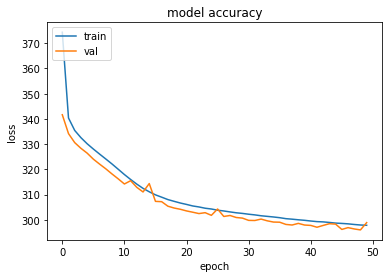

In [ ]:
#plot train loss and validation loss

from matplotlib import pyplot as plt
history = cnn_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#CNN
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 17.3141891600871
Validation rmse: 17.288624788057767


##### **CNN (Adadelta, Epoch - 50, lr = 0.01)**

In [ ]:
#reshape the data as sequential data with scalar feature.
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (392466, 30, 1)
Validation set shape (261644, 30, 1)


In [ ]:
#Set Training Configuration
#40 epochs with minibatch_size=256, learning_rate = 0.0003 training with Adam optimizer.
epochs = 30
batch = 256
lr = 0.01
import tensorflow as tf

adagrad = tf.optimizers.Adagrad(
    learning_rate=lr,
    name='Adadelta',
)

In [ ]:
#Use Conv1D and Maxpool to get a feature of given sequential data. 
#Process this hidden feature with 2 Layer MLP. Predict the value of t+lag, and training the model with mse loss.
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adagrad)
model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 29, 64)            192       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 14, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 896)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                44850     
                                                                 
 dense_13 (Dense)            (None, 1)                 51        
                                                                 
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
__________________________________________________

In [ ]:
#fit the mlp model on trainset. test the performance with validation_data.
cnn_history = model_cnn.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/30
12265/12265 - 59s - loss: 330.3549 - val_loss: 313.7609 - 59s/epoch - 5ms/step
Epoch 2/30
12265/12265 - 52s - loss: 313.7973 - val_loss: 308.5918 - 52s/epoch - 4ms/step
Epoch 3/30
12265/12265 - 51s - loss: 308.8955 - val_loss: 304.3698 - 51s/epoch - 4ms/step
Epoch 4/30
12265/12265 - 49s - loss: 306.1861 - val_loss: 304.1841 - 49s/epoch - 4ms/step
Epoch 5/30
12265/12265 - 58s - loss: 304.3176 - val_loss: 301.4844 - 58s/epoch - 5ms/step
Epoch 6/30
12265/12265 - 57s - loss: 303.0073 - val_loss: 299.7352 - 57s/epoch - 5ms/step
Epoch 7/30
12265/12265 - 70s - loss: 301.9987 - val_loss: 299.2755 - 70s/epoch - 6ms/step
Epoch 8/30
12265/12265 - 67s - loss: 301.1460 - val_loss: 298.4065 - 67s/epoch - 5ms/step
Epoch 9/30
12265/12265 - 59s - loss: 300.4444 - val_loss: 298.0226 - 59s/epoch - 5ms/step
Epoch 10/30
12265/12265 - 75s - loss: 299.8818 - val_loss: 298.3806 - 75s/epoch - 6ms/step
Epoch 11/30
12265/12265 - 72s - loss: 299.4879 - val_loss: 297.2328 - 72s/epoch - 6ms/step
Epoch 12

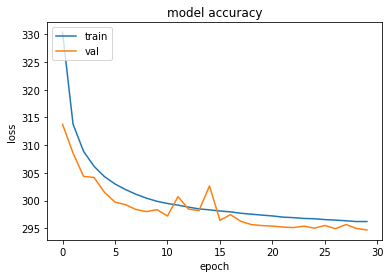

In [ ]:
#plot train loss and validation loss

from matplotlib import pyplot as plt
history = cnn_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#CNN
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 18.311103459496913
Validation rmse: 18.438917373766753


## **LSTM**



> LSTM stands for Long short-term memory. LSTM cells are used in recurrent neural networks that learn to predict the future from sequences of variable lengths. Note that recurrent neural networks work with any kind of sequential data.



The main idea behind LSTM cells is to learn the important parts of the sequence seen so far and forget the less important ones.

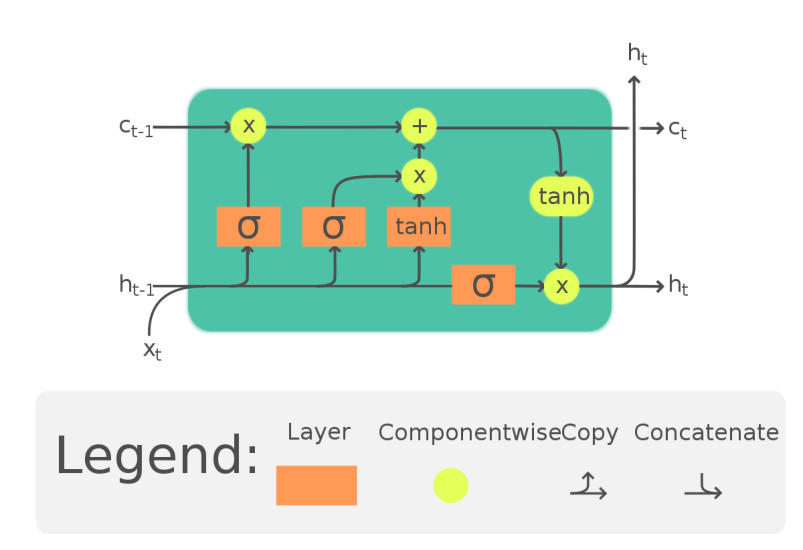

In [ ]:
#Construct a LSTM model.
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
#Process the Sequential model with LSTM.
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the above LSTM model.
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 52s - loss: 1377.8915 - val_loss: 489.1156 - 52s/epoch - 17ms/step
Epoch 2/40
3149/3149 - 48s - loss: 429.0568 - val_loss: 405.5342 - 48s/epoch - 15ms/step
Epoch 3/40
3149/3149 - 47s - loss: 406.0186 - val_loss: 409.9335 - 47s/epoch - 15ms/step
Epoch 4/40
3149/3149 - 47s - loss: 400.7795 - val_loss: 451.2519 - 47s/epoch - 15ms/step
Epoch 5/40
3149/3149 - 49s - loss: 398.5140 - val_loss: 428.2328 - 49s/epoch - 15ms/step
Epoch 6/40
3149/3149 - 61s - loss: 392.6973 - val_loss: 387.3215 - 61s/epoch - 19ms/step
Epoch 7/40
3149/3149 - 47s - loss: 381.6238 - val_loss: 372.5412 - 47s/epoch - 15ms/step
Epoch 8/40
3149/3149 - 47s - loss: 371.6758 - val_loss: 361.4006 - 47s/epoch - 15ms/step
Epoch 9/40
3149/3149 - 47s - loss: 363.6349 - val_loss: 354.4897 - 47s/epoch - 15ms/step
Epoch 10/40
3149/3149 - 47s - loss: 428.9592 - val_loss: 387.6141 - 47s/epoch - 15ms/step
Epoch 11/40
3149/3149 - 47s - loss: 8935.5664 - val_loss: 46236.8555 - 47s/epoch - 15ms/step
Epoch 12/40
314

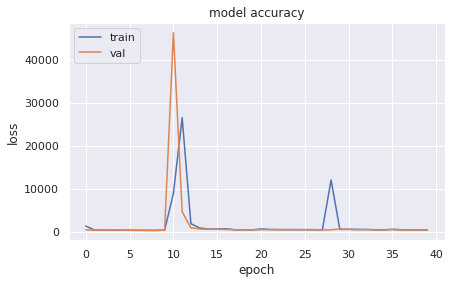

In [ ]:
#Plot train and validation loss
from matplotlib import pyplot as plt
history = lstm_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### **Hyperparameter Tuning**

##### **LSTM (Adadelta, Epoch - 50, lr = 0.01)**

In [ ]:
#Set Training Configuration
#40 epochs with minibatch_size=256, learning_rate = 0.0003 training with Adam optimizer.
epochs = 30
batch = 256
lr = 0.01
import tensorflow as tf

Adadelta = tf.optimizers.Adadelta(
    learning_rate=lr,
    name='Adadelta',
)

In [ ]:
#Construct a LSTM model.
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
#Process the Sequential model with LSTM.
model_lstm.compile(loss='mse', optimizer=Adadelta)
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Train the above LSTM model.
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/30
12265/12265 - 180s - loss: 1678.4149 - val_loss: 979.7723 - 180s/epoch - 15ms/step
Epoch 2/30
12265/12265 - 177s - loss: 884.6573 - val_loss: 808.4829 - 177s/epoch - 14ms/step
Epoch 3/30
12265/12265 - 179s - loss: 730.6733 - val_loss: 672.0026 - 179s/epoch - 15ms/step
Epoch 4/30
12265/12265 - 177s - loss: 624.2615 - val_loss: 610.9285 - 177s/epoch - 14ms/step
Epoch 5/30
12265/12265 - 177s - loss: 583.1088 - val_loss: 535.8831 - 177s/epoch - 14ms/step
Epoch 6/30
12265/12265 - 180s - loss: 529.4220 - val_loss: 525.7401 - 180s/epoch - 15ms/step
Epoch 7/30
12265/12265 - 181s - loss: 487.0808 - val_loss: 436.3023 - 181s/epoch - 15ms/step
Epoch 8/30
12265/12265 - 183s - loss: 442.4454 - val_loss: 423.7461 - 183s/epoch - 15ms/step
Epoch 9/30
12265/12265 - 180s - loss: 412.4392 - val_loss: 397.0201 - 180s/epoch - 15ms/step
Epoch 10/30
12265/12265 - 180s - loss: 399.2418 - val_loss: 400.0720 - 180s/epoch - 15ms/step
Epoch 11/30
12265/12265 - 194s - loss: 422.3413 - val_loss: 402.0092

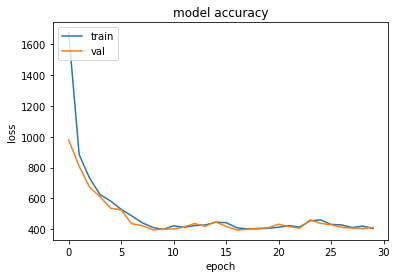

In [ ]:
#Plot train and validation loss
from matplotlib import pyplot as plt
history = lstm_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#LSTM
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

Train rmse: 20.353464403828784
Validation rmse: 17.167550656998447


## **LSTM + CNN**

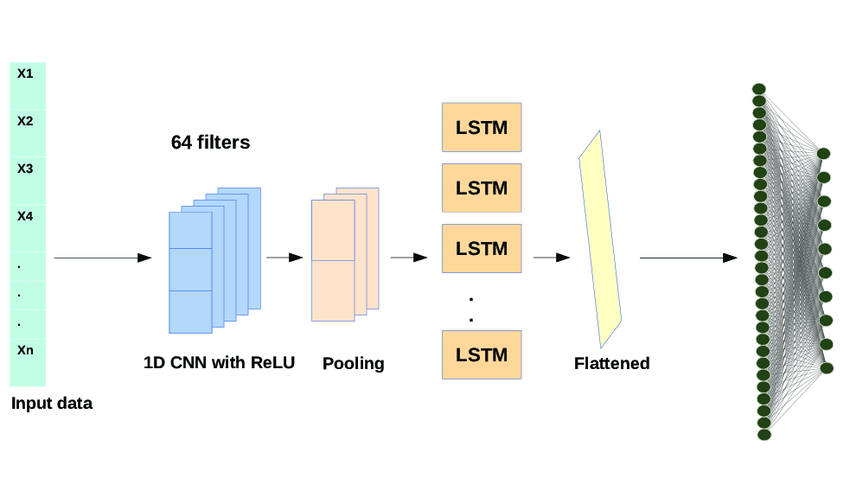



> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."



> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."



> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/






In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (100746, 2, 15, 1)
Validation set shape (67164, 2, 15, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
#Model
model_cnn_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 15, 64)     128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 7, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 448)        0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 50)                99800     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                      

In [ ]:
#Train
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 51s - loss: 440.7550 - val_loss: 419.0641 - 51s/epoch - 16ms/step
Epoch 2/40
3149/3149 - 19s - loss: 413.1339 - val_loss: 404.4534 - 19s/epoch - 6ms/step
Epoch 3/40
3149/3149 - 20s - loss: 402.2363 - val_loss: 398.1948 - 20s/epoch - 6ms/step
Epoch 4/40
3149/3149 - 18s - loss: 393.9443 - val_loss: 389.9102 - 18s/epoch - 6ms/step
Epoch 5/40
3149/3149 - 20s - loss: 390.1692 - val_loss: 397.3135 - 20s/epoch - 6ms/step
Epoch 6/40
3149/3149 - 21s - loss: 387.9122 - val_loss: 383.2030 - 21s/epoch - 7ms/step
Epoch 7/40
3149/3149 - 20s - loss: 386.4767 - val_loss: 385.6756 - 20s/epoch - 6ms/step
Epoch 8/40
3149/3149 - 18s - loss: 385.7023 - val_loss: 381.2297 - 18s/epoch - 6ms/step
Epoch 9/40
3149/3149 - 20s - loss: 384.3217 - val_loss: 384.4532 - 20s/epoch - 6ms/step
Epoch 10/40
3149/3149 - 19s - loss: 383.9566 - val_loss: 381.7448 - 19s/epoch - 6ms/step
Epoch 11/40
3149/3149 - 25s - loss: 387.4520 - val_loss: 385.9269 - 25s/epoch - 8ms/step
Epoch 12/40
3149/3149 - 23s -

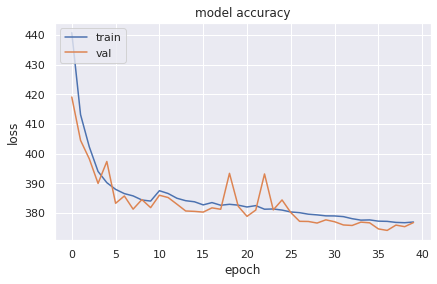

In [ ]:
#Plot the loss
from matplotlib import pyplot as plt
history = cnn_lstm_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **RSME** Model Comparison

In [ ]:
#MLP
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 17.252252724403974
Validation rmse: 17.22032092983257


In [ ]:
#CNN
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 18.562083324191132
Validation rmse: 18.66202570360532


In [ ]:
#LSTM
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

Train rmse: 21.126108499623076
Validation rmse: 18.66202570360532


In [ ]:
#CNN_LSTM
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

Train rmse: 19.412205435517137
Validation rmse: 19.4087974685216


## **Conclusion**




> MLP's performance is the best among models.


*   this experiment shows limit of LSTM-based (or Sliding window) models.
*   In this problem the importance of old data is much higher than recent data.

*   As MLP does not forget the old values, it worked best. Also CNN model works well because it also observes whole sequence without forgetting.



> CNN-LSTM's stable fitting

*   Conv1d on subsequence smoothes the noise in each time-step.
*   Therefore, CNN-LSTM fits stably than LSTM model.










# **Approach 3** - Prophet

Facebook Prophet is an open-source algorithm for generating time-series models that uses a few old ideas with some new twists. It is particularly good at modeling time series that have multiple seasonalities and doesn’t face some of the mentioned below drawbacks of other algorithms. At its core is the sum of three functions of time plus an error term: growthg(t), seasonality s(t), holidays h(t) , and error e_t.

Traditional time series models like ARIMAX have many stringent data requirements like stationarity and equally spaced values. Other time series models like Recurring Neural Networks with Long-Short Term Memory (RNN-LSTM) can be highly complex and difficult to work with if you don’t have a significant level of understanding about neural network architecture.

In its essence, this library utilizes the additive regression model  y(t)  comprising the following components:


> y(t)=g(t)+s(t)+h(t)+ϵt

where,

*   Trend  g(t)  models non-periodic changes.
*   Seasonality  s(t)  represents periodic changes.


*   Holidays component  h(t)  contributes information about holidays and events
*   The error term  ϵ(t)  represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.




### **Import**

In [ ]:
import pandas as pd # Import Pandas for data manipulation using dataframes
import numpy as np # Import Numpy for data statistical analysis 
import matplotlib.pyplot as plt # Import matplotlib for data visualisation
import random
import seaborn as sns
from fbprophet import Prophet
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [ ]:
train_data = pd.read_csv("train.csv" , parse_dates=['date'])
#Adding new coloums - month year
train_data['Month']=train_data['date'].dt.month
train_data['Year']=train_data['date'].dt.year

In [ ]:
train_data

,date,store,item,sales,Month,Year
0,2013-01-01,1,1,13,1,2013
1,2013-01-02,1,1,11,1,2013
2,2013-01-03,1,1,14,1,2013
3,2013-01-04,1,1,13,1,2013
4,2013-01-05,1,1,10,1,2013
...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,12,2017
912996,2017-12-28,10,50,59,12,2017
912997,2017-12-29,10,50,74,12,2017
912998,2017-12-30,10,50,62,12,2017


In [ ]:
#Sort
train_data=train_data.sort_values(['date'])

### **Visualize**

<Figure size 720x2160 with 0 Axes>

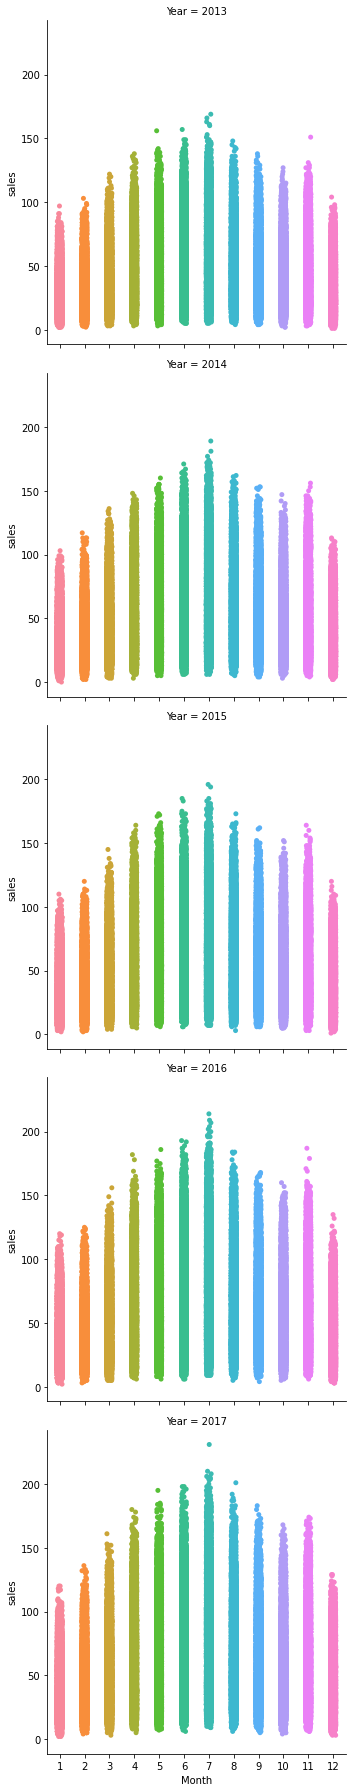

In [ ]:
#Visualize yearly trend
train_data['Month']=train_data['date'].dt.month
train_data['Year']=train_data['date'].dt.year
plt.figure(figsize=(10,30))
sns.catplot(data = train_data, x ='Month', y = "sales",row = "Year")
plt.show()

### **Training**

In [ ]:
#renaming column
train_data=train_data.rename(columns={'date':'ds','sales':'y'})
train_data

,ds,store,item,y,Month,Year
0,2013-01-01,1,1,13,1,2013
211816,2013-01-01,7,12,26,1,2013
832656,2013-01-01,7,46,27,1,2013
213642,2013-01-01,8,12,54,1,2013
215468,2013-01-01,9,12,35,1,2013
...,...,...,...,...,...,...
619013,2017-12-31,9,34,21,12,2017
620839,2017-12-31,10,34,32,12,2017
622665,2017-12-31,1,35,55,12,2017
598927,2017-12-31,8,33,100,12,2017


In [ ]:
#traing 
model=Prophet(yearly_seasonality=True)
model.fit(train_data)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### **Forecast**







*   **ds :** contains the timestamp entry of the forecast

*   **yhat :** contains the forecasted value of the time series
*   **yhat_lower :** contains the bottom of the confidence interval for the forecast


*   **yhat_upper :** contains the bottom of the confidence interval for the forecast



In [ ]:
forecast=model.make_future_dataframe(periods=90)
forecast=model.predict(forecast)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2013-01-01,26.760046,-6.270980,60.777605
1,2013-01-02,26.791287,-6.498470,60.401827
2,2013-01-03,30.022893,-2.941696,63.405771
3,2013-01-04,33.324678,-0.850885,63.477895
4,2013-01-05,36.691746,2.228842,70.211865
...,...,...,...,...
1911,2018-03-27,54.933405,23.030684,87.656051
1912,2018-03-28,55.340600,22.510984,87.547722
1913,2018-03-29,58.972904,26.448738,93.607721
1914,2018-03-30,62.697232,29.792185,95.857338


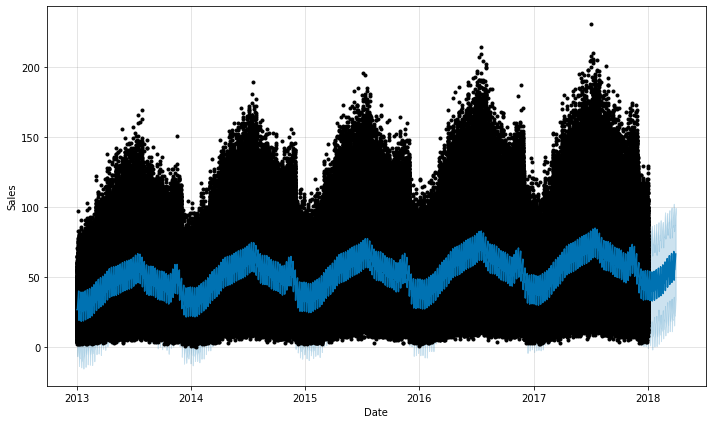

In [ ]:
#Visualize results
figure=model.plot(forecast,xlabel='Date',ylabel='Sales')
model.plot()

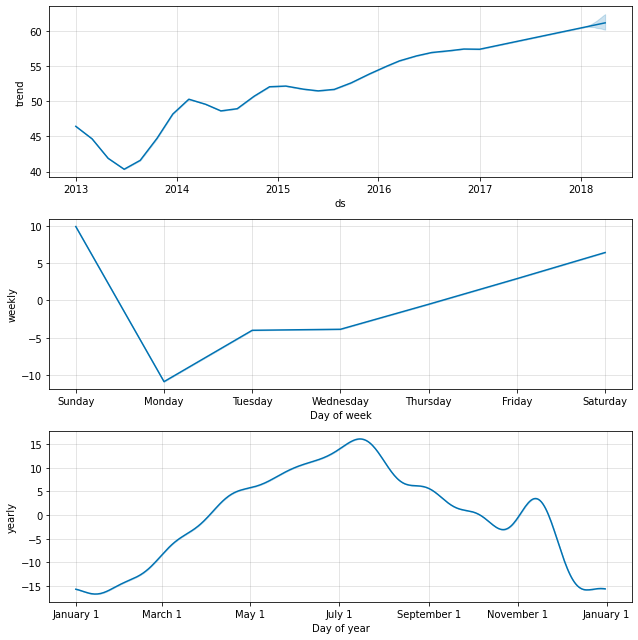

In [ ]:
# Yearly, Weakly trend 
figure2=model.plot_components(forecast)

### **Conclusion**



*   This is the easiest approach for time series problems 
*   Model have prebuild classes to visualize results based on data






# **Final Conclusion**




> In this notebook we succefully implemented 3 approaches to solve time series problem and saw how such algorithms can forecast future




*   lightGBM worked best for this dataset.
*   Deep Learning also worked well and it might have worked even better with bigger and complex models.
*   Approach using facebook Prophet was easy and fast to implement 




# **References**



*   https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a
*   https://towardsdatascience.com/the-best-deep-learning-models-for-time-series-forecasting-690767bc63f0

*   https://neptune.ai/blog/arima-vs-prophet-vs-lstm

*   https://iopscience.iop.org/article/10.1088/1742-6596/1693/1/012110/pdf

* https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/

* https://towardsdatascience.com/multi-step-time-series-forecasting-with-arima-lightgbm-and-prophet-cc9e3f95dfb0


